In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
importlib.reload(src)

import src.utils.metrics as metrics
import src.utils.gau as gaussian
import src.utils.plots as plots

from src.models import AE, RNN, LinearClassifier, get_latent_features, rnn_loss_function, ae_loss_function
from src.training import EarlyStopping, train_ae, train_rnn, train_lp, augment_data

from src.final_model import ae_loss_function, rnn_loss_function

c:\Users\pmarc\.conda\envs\inteli_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')

def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

rename_labels(stamps_dataset, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

In [3]:
train_template = torch.tensor(stamps_dataset['Train']['template'], dtype=torch.float32)
validation_template = torch.tensor(stamps_dataset['Validation']['template'], dtype=torch.float32)
test_template = torch.tensor(stamps_dataset['Test']['template'], dtype=torch.float32)

train_difference = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
validation_difference = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
test_difference = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)

train_image = torch.tensor(stamps_dataset['Train']['images'], dtype=torch.float32)
validation_image = torch.tensor(stamps_dataset['Validation']['images'], dtype=torch.float32)
test_image = torch.tensor(stamps_dataset['Test']['images'], dtype=torch.float32)

train_class_0 = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)
validation_class_0 = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)
test_class_0 = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

train_template = train_template.unsqueeze(1).repeat(1, 5, 1, 1)
validation_template = validation_template.unsqueeze(1).repeat(1, 5, 1, 1)
test_template = test_template.unsqueeze(1).repeat(1, 5, 1, 1)


train_dataset = torch.stack((train_template, train_image, train_difference), dim=3  )
validation_dataset = torch.stack((validation_template, validation_difference, validation_difference), dim=3)
test_dataset = torch.stack((test_template, test_image, test_difference), dim=3)

train_template = train_template.unsqueeze(2)  # (samples, 5, 1, 21, 21)
train_image = train_image.unsqueeze(2)        
train_difference = train_difference.unsqueeze(2)  

validation_template = validation_template.unsqueeze(2)
validation_image = validation_image.unsqueeze(2)
validation_difference = validation_difference.unsqueeze(2)

test_template = test_template.unsqueeze(2)
test_image = test_image.unsqueeze(2)
test_difference = test_difference.unsqueeze(2)

# Apilar los tensores a lo largo de la dimensión correcta
train_dataset = torch.cat((train_template, train_image, train_difference), dim=2)
validation_dataset = torch.cat((validation_template, validation_image, validation_difference), dim=2)
test_dataset = torch.cat((test_template, test_image, test_difference), dim=2)

# Crear los conjuntos de datos
train_dataset = TensorDataset(train_dataset, train_class_0)
validation_dataset = TensorDataset(validation_dataset, validation_class_0)
test_dataset = TensorDataset(test_dataset, test_class_0)

In [4]:
#rnn parameters
rnn_type = 'LSTM'
hidden_dim = 128
num_layers = 2

# autoencoder params
latent_dim = 50
n_channels = 3
n_classes = 3

# training params
ae_loss = ae_loss_function
rnn_loss = rnn_loss_function

max_epochs = 100
max_time = 600 #minutos
lr = 0.666e-3
batch_size = 256

random_sampler = True
use_gpu = True
augmentation = False
early_stop = 5
num_cpu = 18



In [36]:
import src.final_model as fm
import src.final_training as ft
importlib.reload(fm)
importlib.reload(ft)
importlib.reload(src.final_training)
importlib.reload(src.final_model)

modelo_final = fm.FinalModel(latent_dim, n_channels, rnn_type, hidden_dim, num_layers, n_classes, name='final', description='entrenado con dataset completo, loss function separada en etapas con espacio latente intermedio rnn.')

stage = 'ae_alone'
curves = ft.train_final_model(modelo_final,
                                              stage,
                                                train_dataset,
                                                validation_dataset,
                                                ae_loss,
                                                rnn_loss,
                                                max_epochs,
                                                max_time,
                                                batch_size,
                                                lr,
                                                random_sampler,
                                                augmentation,
                                                early_stop,
                                                use_gpu,
                                                num_cpu)

torch.save(modelo_final.state_dict(), 'models/modelo_final.pth')


Setup finishied. Starting training...
(13.25 min) Epoch 21/100 (Early Stop) -- Iteration 10122 - Batch 481/482 - Train loss: 0.00162242 - Val loss: 0.00042830

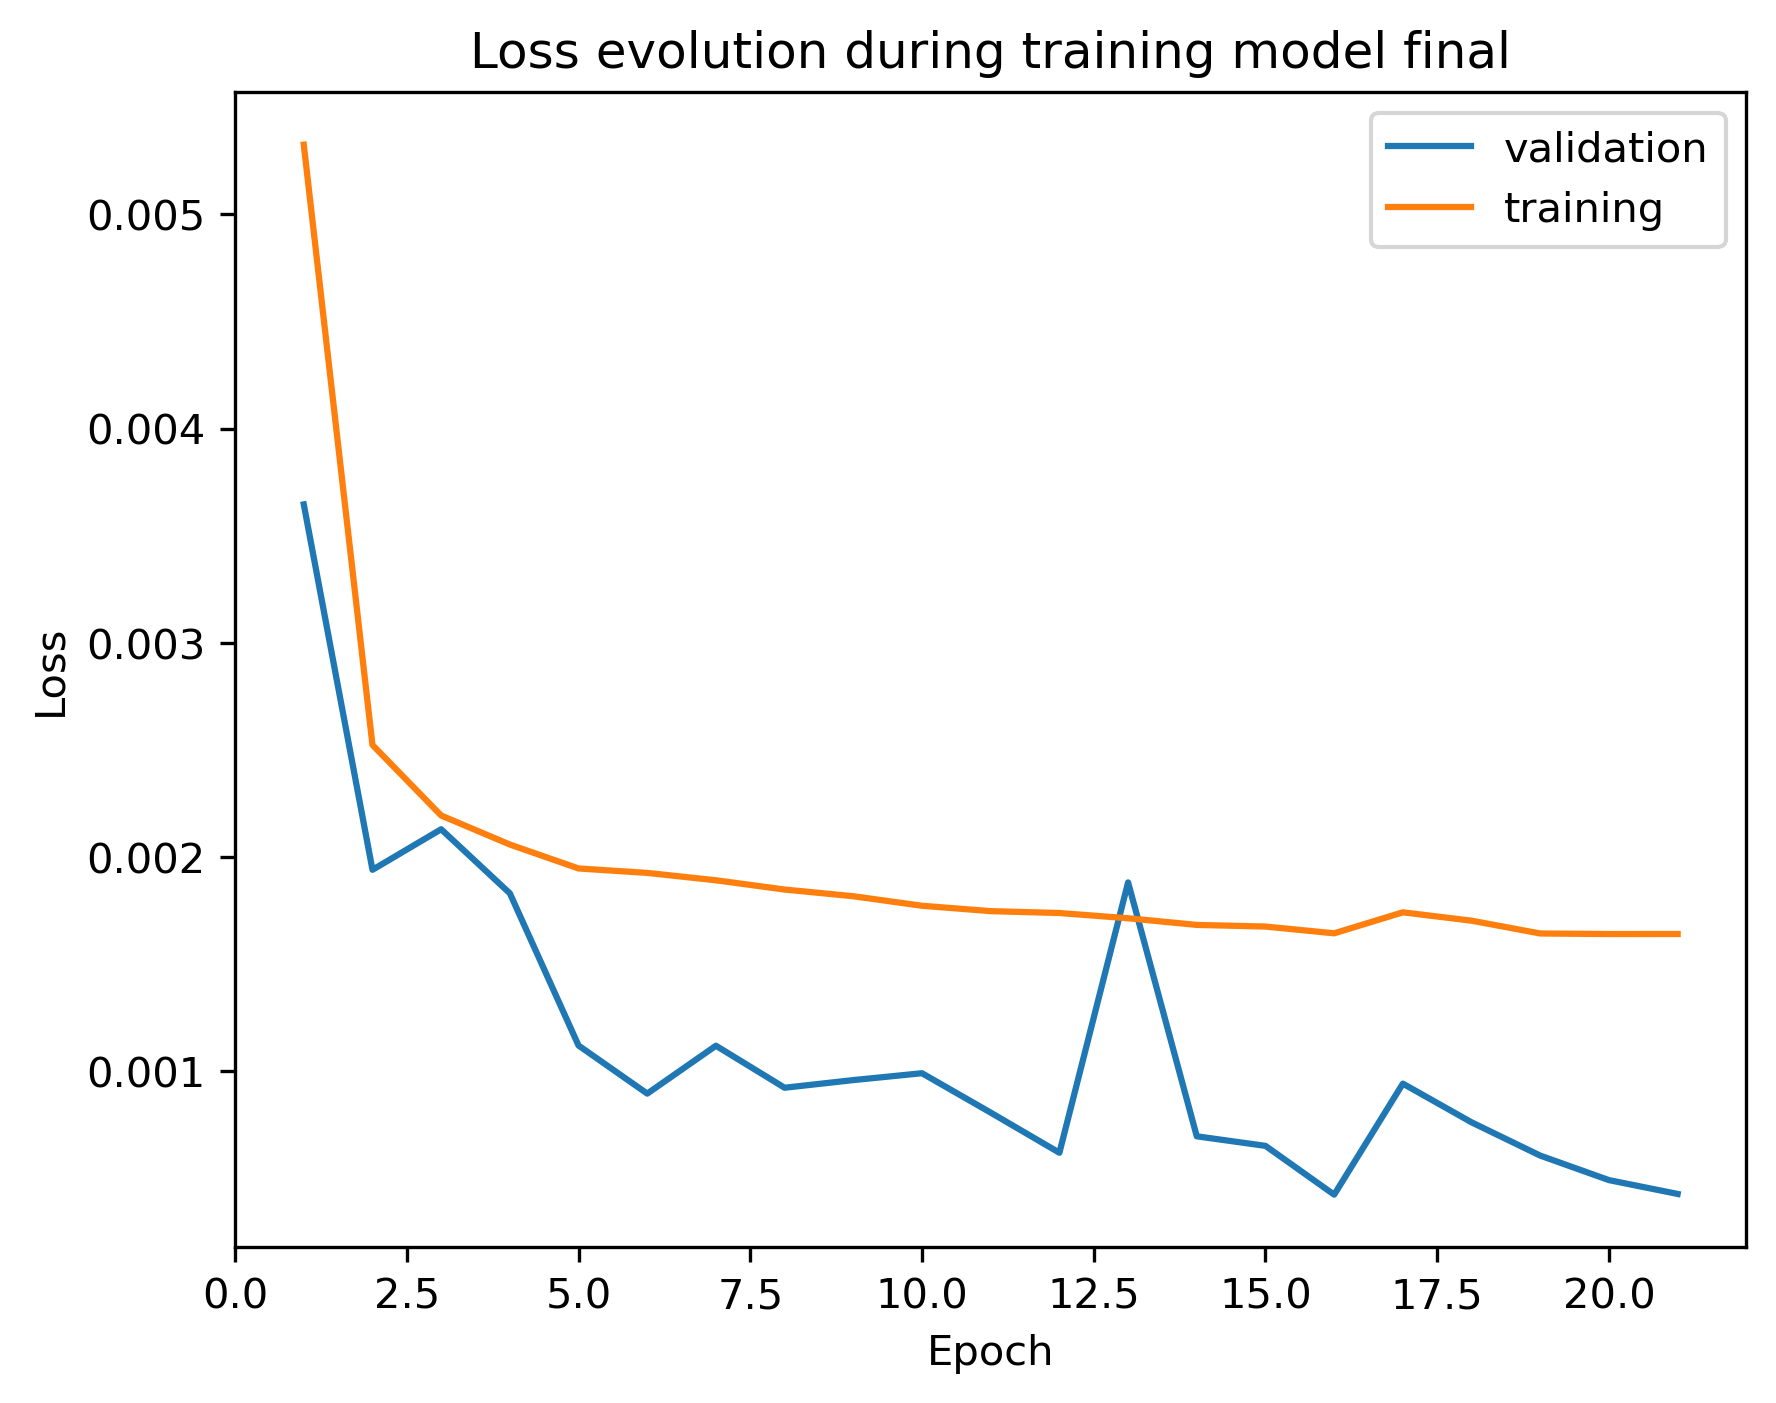

In [37]:
metrics.show_curves([curves], [modelo_final])
print()

In [33]:
import src.final_model as fm
import src.final_training as ft
importlib.reload(fm)
importlib.reload(ft)
importlib.reload(src.final_training)
importlib.reload(src.final_model)

stage = 'ae_rnn'
curves = ft.train_final_model(modelo_final,
                                              stage,
                                                train_dataset,
                                                validation_dataset,
                                                ae_loss,
                                                rnn_loss,
                                                max_epochs,
                                                max_time,
                                                batch_size,
                                                lr,
                                                random_sampler,
                                                augmentation,
                                                early_stop,
                                                use_gpu,
                                                num_cpu)

torch.save(modelo_final.state_dict(), 'models/modelo_final.pth')


Setup finishied. Starting training...
(6.14 min) Epoch 15/100 (Early Stop) -- Iteration 7230 - Batch 481/482 - Train loss: 0.00164483 - Val loss: 0.00084882

In [ ]:
metrics.show_curves([curves], [modelo_final])
print()

In [38]:
importlib.reload(src)

stage = 'rnn'
curves = ft.train_final_model(modelo_final,
                                              stage,
                                                train_dataset,
                                                validation_dataset,
                                                ae_loss,
                                                rnn_loss,
                                                max_epochs,
                                                max_time,
                                                batch_size,
                                                lr,
                                                random_sampler,
                                                augmentation,
                                                early_stop,
                                                use_gpu,
                                                num_cpu)

torch.save(modelo_final.state_dict(), 'models/modelo_final.pth')


Setup finishied. Starting training...
(2.19 min) Epoch 6/100 (Early Stop) -- Iteration 2892 - Batch 481/482 - Train loss: 0.11803576 - Val loss: 2.36187315

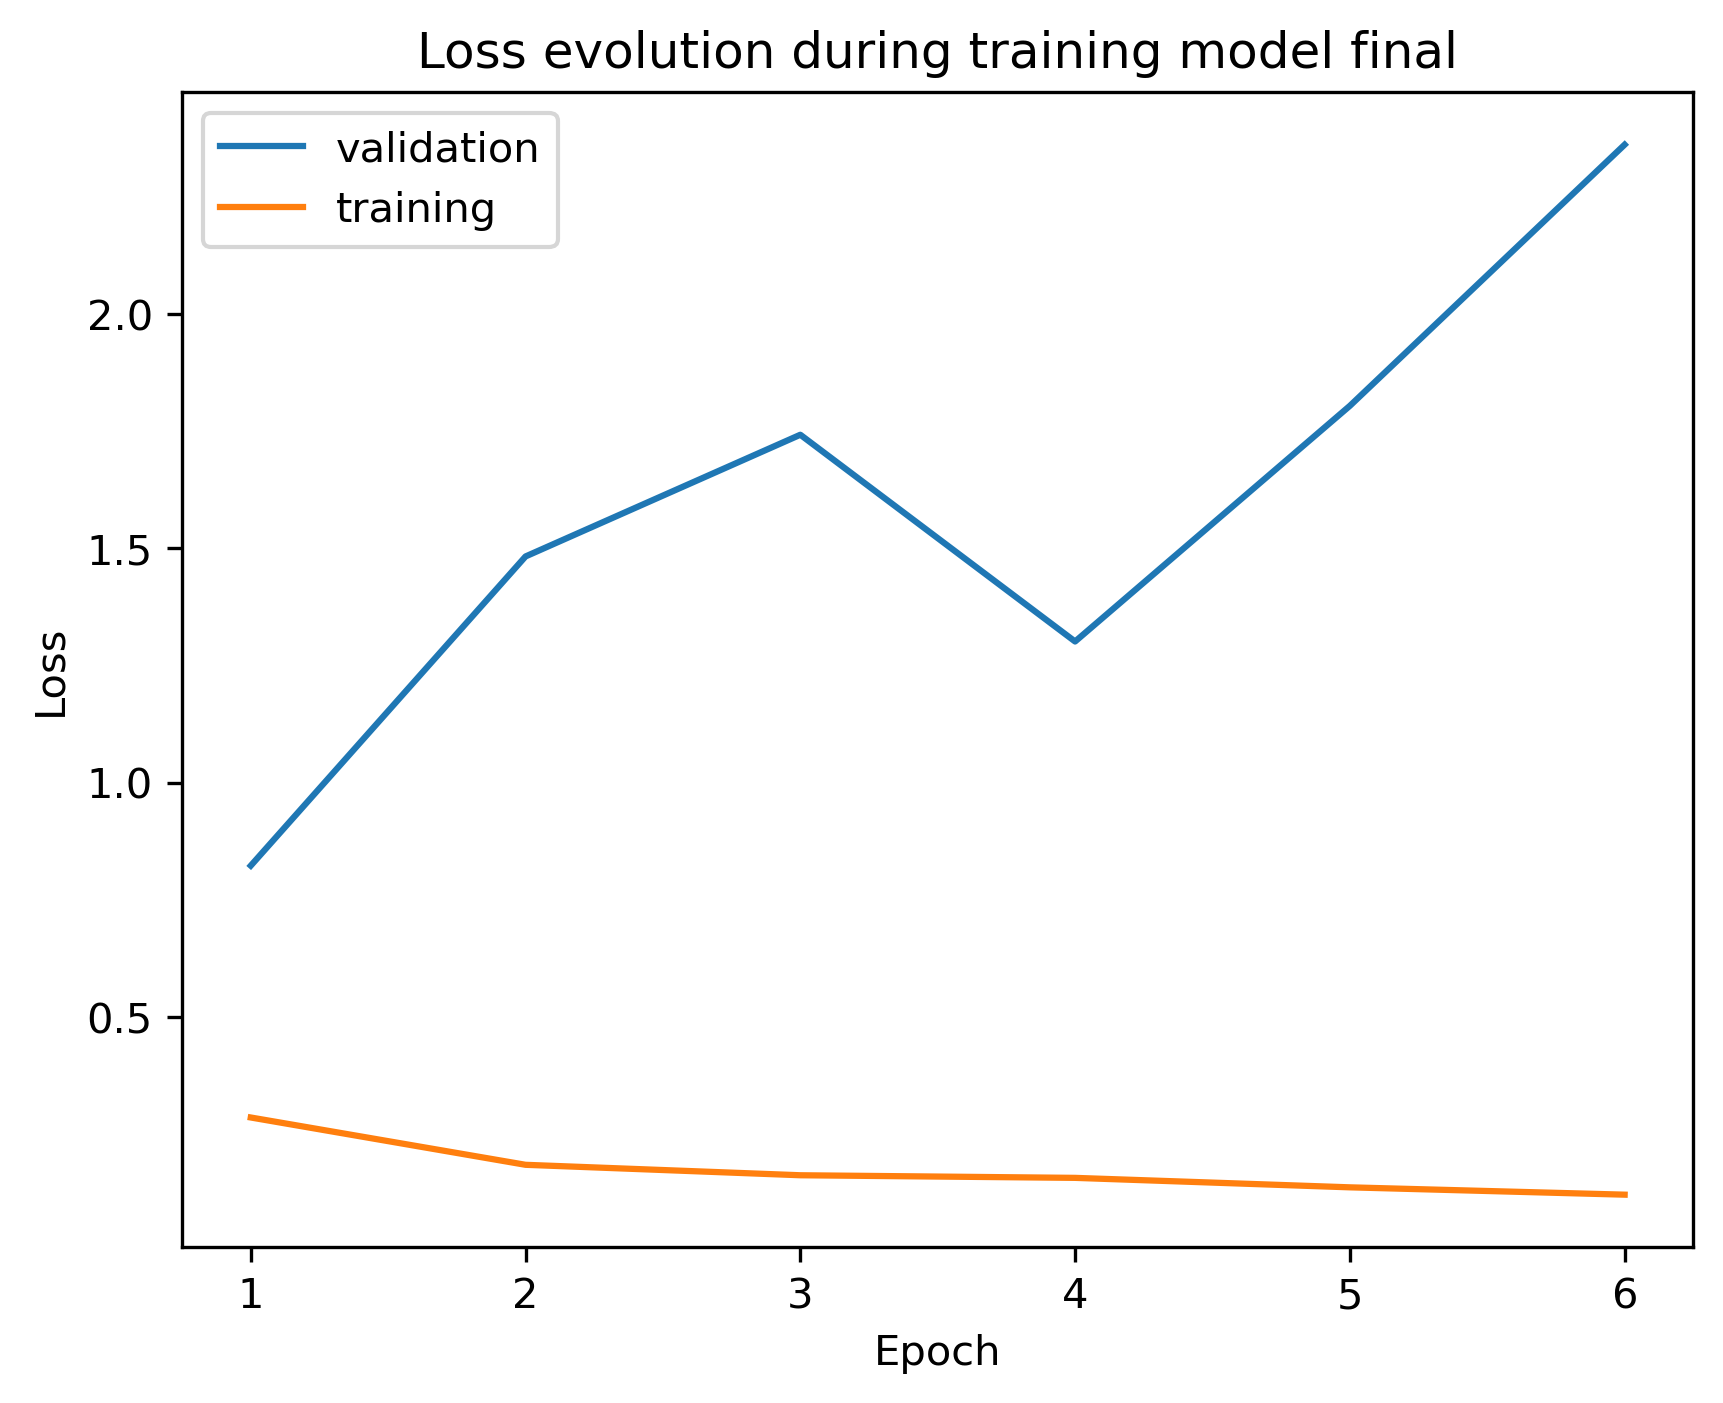

In [39]:
metrics.show_curves([curves], [modelo_final])
print()


Modelo final
Precision: 0.621
Recall: 0.582
F1: 0.587


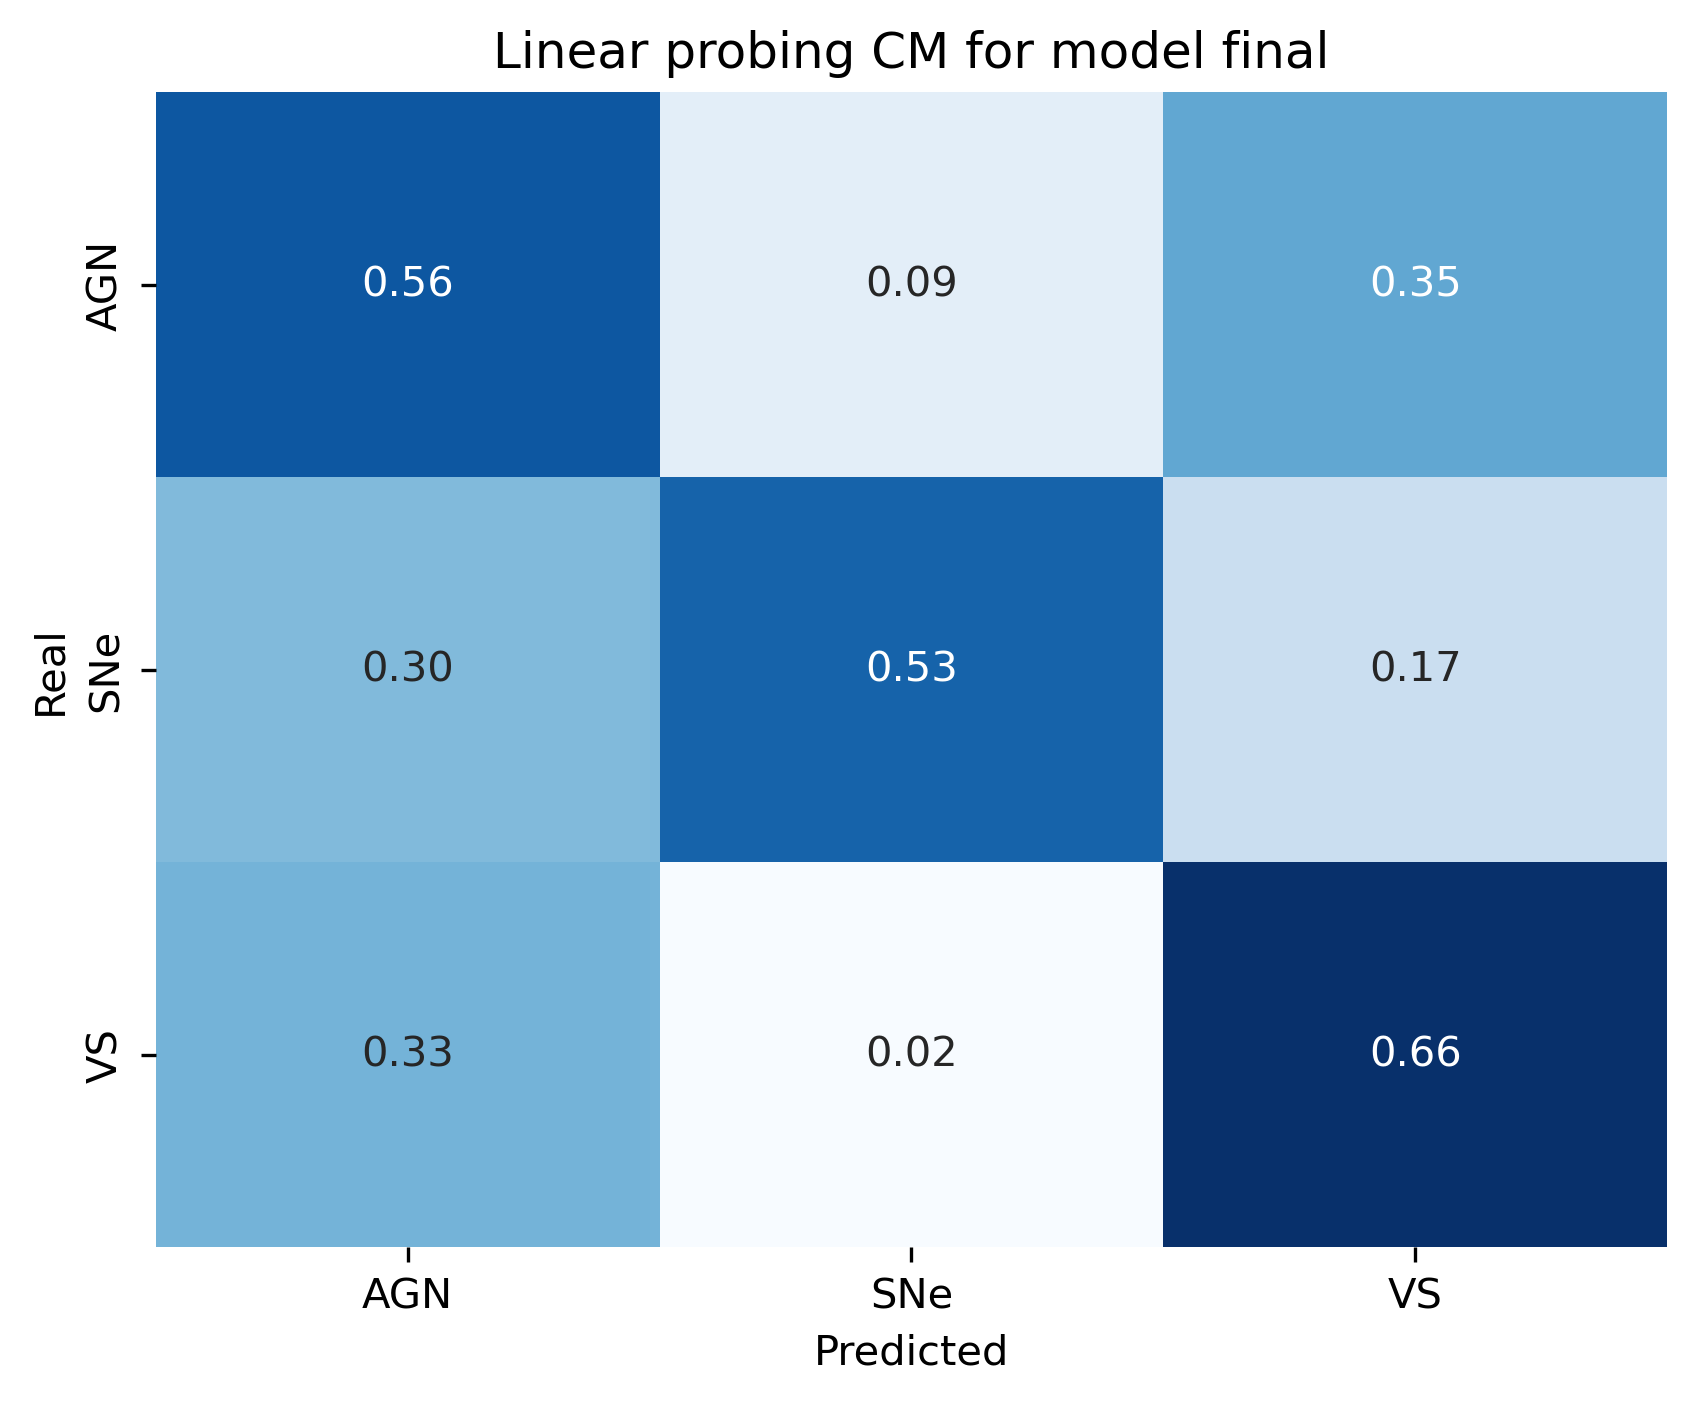

In [40]:


modelo_final.eval()

prediction = modelo_final.rnn_classifier(test_dataset.tensors[0])

cm = confusion_matrix(test_dataset.tensors[1], prediction.argmax(dim=1), normalize='true')
print(f'\nModelo {modelo_final.name}')
metrics.plot_matrix([modelo_final], [cm])
precision, recall, f1 = metrics.performance_metrics(test_dataset.tensors[1], prediction.argmax(dim=1))

print(f'Precision: {precision:.3f}'
      f'\nRecall: {recall:.3f}'
      f'\nF1: {f1:.3f}')


In [ ]:
test_dataset.tensors[0].shape

torch.Size([600, 5, 3, 21, 21])

: 